In [33]:
import xarray as xr
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from xeofs.single import EOF

In [2]:
if torch.cuda.is_available():
  print("GPU detected")
  device = torch.device("cuda")
else:
  print("No GPU detected")
  device = torch.device("cpu")

GPU detected


***Building encoder***

In [90]:
class Encoder(nn.Module):
    def __init__(self, input_dim=492, hidden_dim1=1024, hidden_dim2 = 256, latent_dim=20):
        super(Encoder, self).__init__()
        self.fc0 = nn.Linear(input_dim, hidden_dim1)
        self.fc1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc0(x))
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [91]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim1=1024, hidden_dim2 = 256, output_dim=492):
        super(Decoder, self).__init__()
        self.fc0 = nn.Linear(latent_dim, hidden_dim2)
        self.fc1 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, output_dim)

    def forward(self, z):
        q = torch.relu(self.fc0(z))
        h = torch.relu(self.fc1(q))
        out = torch.relu(self.fc2(h))
        return out

In [77]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim=492, hidden_dim1=1024, hidden_dim2 = 256, latent_dim=20):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim = input_dim, hidden_dim1 = hidden_dim1, hidden_dim2 = hidden_dim2, latent_dim = latent_dim)
        self.decoder = Decoder(latent_dim = latent_dim, hidden_dim1 = hidden_dim1, hidden_dim2 = hidden_dim2, output_dim = input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar


In [78]:
def evaluate_loss(autoencoder, dataloader, device):
    autoencoder.eval()
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)
            x_hat, mu, logvar = autoencoder(x)
            recon_loss = ((x - x_hat)**2).sum(dim=1)  # sum over features per sample
            kl_loss = kl_divergence(mu, logvar)
            batch_loss = (recon_loss + kl_loss).sum().item()
            
            total_loss += batch_loss
            total_samples += x.size(0)
    avg_loss = total_loss / total_samples
    return avg_loss


In [99]:
def kl_divergence(mu, logvar):
    # mu, logvar: tensors of shape (batch_size, latent_dim)
    # Returns: mean KL divergence per sample (scalar)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return kl.mean()

def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)
    patience = 3         # Number of epochs to wait for improvement
    best_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat, mu, logvar = autoencoder(x)
            recon_loss = ((x - x_hat)**2).sum(dim=1)
            kl_loss = kl_divergence(mu, logvar)
            loss = recon_loss + kl_loss
            loss.backward()
            opt.step() 
        loss = evaluate_loss(autoencoder, data, device)
        print(f'Loss at Epoch {epoch}: {loss:.4f}')
        # Early stopping check
        if loss < best_loss:
            best_loss = loss
            epochs_no_improve = 0
            best_model_state = autoencoder.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs with no improvement.")
                break
                autoencoder.load_state_dict(best_model_state)
                print("Best model state restored")
                print(f"Best val loss: {best_loss:.4f}")
    return autoencoder

In [80]:
def reconstruct_sst(autoencoder, dataloader, device):
    autoencoder.eval()  # put in eval mode

    latents_mu = []
    latents_logvar = []

    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)
            mu, logvar = autoencoder.encoder(x)  # only run encoder
            latents_mu.append(mu.cpu())
            latents_logvar.append(logvar.cpu())

    # Concatenate results to a tensor of shape (num_samples, latent_dim)
    latents_mu = torch.cat(latents_mu, dim=0)
    latents_logvar = torch.cat(latents_logvar, dim=0)

    return latents_mu, latents_logvar




In [81]:
ssts = xr.open_dataset('Datasets/EMD_Detrended_SST_anoms.nc').sel(time = slice('1982-01-01','2022-12-31'))['__xarray_dataarray_variable__']
ssts = ssts.drop_vars(['spatial_ref','month']).stack(pixel = ('lat','lon')).dropna(dim = 'pixel', how = 'any')

In [82]:
class TimeSeriesDataset(Dataset):
    def __init__(self, stacked_da):  # expects xarray DataArray with shape (site, time)
        self.data = torch.tensor(stacked_da.values, dtype=torch.float32)
        # If you have targets, do similar
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]  # or (self.data[idx], self.targets[idx])

# Build dataset
dataset = TimeSeriesDataset(ssts)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)  # batch_size=1 since NN sees one site/time series at a time


In [101]:
vae = VariationalAutoencoder(input_dim = ssts.shape[1], hidden_dim1 = 1024, hidden_dim2 = 256, latent_dim = 40).to(device)

In [102]:
trained_vae = train(vae, data_loader, epochs = 20)

Loss at Epoch 0: 33764.6354
Loss at Epoch 1: 32130.2844
Loss at Epoch 2: 30896.6068
Loss at Epoch 3: 29874.9831
Loss at Epoch 4: 29155.2171
Loss at Epoch 5: 28227.0176
Loss at Epoch 6: 27803.0996
Loss at Epoch 7: 27369.2843
Loss at Epoch 8: 26826.8563
Loss at Epoch 9: 26452.4500
Loss at Epoch 10: 26232.5022
Loss at Epoch 11: 25827.2858
Loss at Epoch 12: 25610.2743
Loss at Epoch 13: 25224.7706
Loss at Epoch 14: 25064.3072
Loss at Epoch 15: 24753.4490
Loss at Epoch 16: 24733.4910
Loss at Epoch 17: 24395.1305
Loss at Epoch 18: 24285.5661
Loss at Epoch 19: 24099.3234


In [24]:
recon_mu, recon_logvar = reconstruct_sst(trained_vae, data_loader, device)

In [25]:
recon_np = recon_mu.cpu().numpy() if isinstance(recon_mu, torch.Tensor) else recon_mu

recon_xr = xr.DataArray(
    recon_np.T,
    dims=('mode', 'time'),
    coords={'time': ssts['time']}
)

In [26]:
recon_xr.shape

(10, 492)

In [29]:
def plot_reconstruction_corrs(recon, original):
    fig, axs = plt.subplots(ncols = 1, nrows = recon.shape[0],figsize = (8, 8*recon.shape[0]))
    for i in range(recon.shape[0]):
        xr.corr(recon.sel(mode = i),original, dim = 'time').unstack().plot(ax = axs[i])
    plt.show()

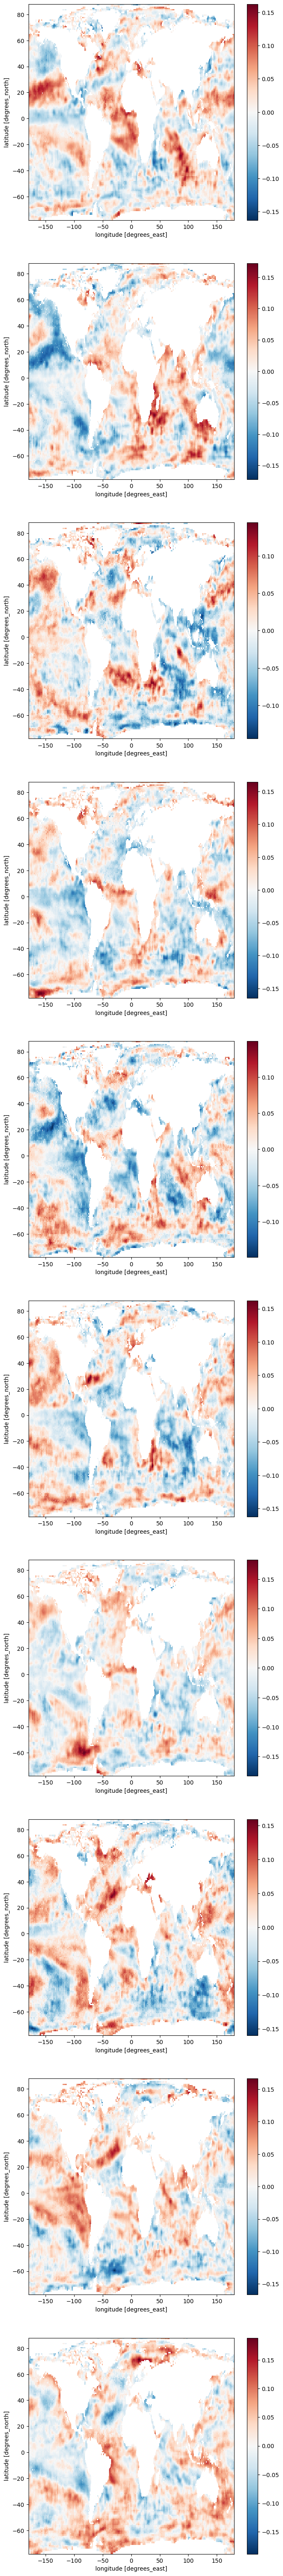

In [30]:
plot_reconstruction_corrs(recon_xr, ssts)

In [45]:
original_tensor.shape

torch.Size([492, 39735])

In [46]:
recon_mu.shape

torch.Size([492, 10])

In [52]:
from sklearn.linear_model import LinearRegression

def latent_explained_variance(latents, original):
    """
    Compute the explained variance of the original data by
    the latent features using per-time-step linear regression.

    Args:
        latents: array-like, shape (num_samples, latent_dim)
            Encoded latent features (mu or z) per site.
        original: array-like, shape (num_samples, time_steps)
            Original time series per site.

    Returns:
        ev_per_site: array of explained variance per site.
        mean_ev: mean explained variance over all sites.
        reconstructed: predicted reconstruction from latent features, shape (num_samples, time_steps)
    """
    X = np.array(latents)
    Y = np.array(original)
    n_sites, n_steps = Y.shape

    # Linear regression (per time step)
    Y_hat = np.zeros_like(Y)
    for t in range(n_steps):
        lr = LinearRegression()
        lr.fit(X, Y[:, t])
        Y_hat[:, t] = lr.predict(X)

    # Explained variance (per site)
    mean = Y.mean(axis=1, keepdims=True)
    ss_total = ((Y - mean)**2).sum(axis=1)
    ss_res = ((Y - Y_hat)**2).sum(axis=1)
    ev_per_site = 1 - ss_res / ss_total
    mean_ev = ev_per_site.mean()

    return ev_per_site, mean_ev, Y_hat

# Example usage:
# latents_mu: shape (num_sites, latent_dim)
# stacked.values: shape (num_sites, time_steps)
ev_per_step, mean_ev, Y_hat = latent_explained_variance(recon_mu, ssts.values)
print(f"Mean explained variance: {mean_ev:.4f}")

Mean explained variance: -0.0003


In [59]:
ev_per = xr.DataArray(ev_per_step, coords = {'time': ssts['time']})
Y_pred = xr.DataArray(Y_hat, coords = {'time':ssts['time'],'pixel':ssts['pixel']})

In [44]:
def explained_variance(original, reconstructed):
    # original, reconstructed: tensors of shape (num_pixels, time_steps)
    original_mean = torch.mean(original, dim=1, keepdim=True)
    ss_total = torch.sum((original - original_mean)**2, dim=1)
    ss_res = torch.sum((original - reconstructed)**2, dim=1)
    ev = 1 - ss_res / ss_total  # explained variance per pixel
    return ev

original_tensor = torch.tensor(ssts.values, dtype=torch.float32)
ev_per_pixel = explained_variance(original_tensor.T, recon_mu)

# Average explained variance across all sites
mean_ev = ev_per_pixel.mean().item()
print(f"Mean Explained Variance: {mean_ev:.4f}")


RuntimeError: The size of tensor a (492) must match the size of tensor b (10) at non-singleton dimension 1

***Linear PCA for comparison***

In [34]:
# Filler basic pca function
def linear_pca(data, n_pcs = 8):
    pca = EOF(n_modes = n_pcs)
    pcs = pca.fit_transform(data, dim = 'time').rename({'mode':'pcs'})
    return pca, pcs

# Plot important stats for a given pc
def plot_pc_info(pca, pcs, mode = 'all'):
    if mode == 'all':
        exp_vars = pca.explained_variance_ratio().values
        n_pcs = len(exp_vars)
        fig, ax = plt.subplots(nrows = n_pcs, ncols = 2, figsize = (10, 4*n_pcs), layout = 'constrained')
        fig.suptitle(f"{n_pcs} PCs of SST data; Total Exp. Var: {sum(exp_vars):.4f}")
        for i in range(n_pcs):
            pcs.sel(pcs = i+1).plot(ax = ax[i,0])
            pca.components().sel(mode = i+1).unstack().plot(ax = ax[i,1])
            ax[i,0].set_title(f"PC{i+1} of SST data")
            ax[i,1].set_title(f"Explained Var: {exp_vars[i]:.4f}")
    else:
        fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (10,8), layout = 'constrained')
        fig.suptitle(f"PC{mode} of SST data and components, exp. var: {pca.explained_variance_ratio()[mode].values:.4f}")
        pcs.sel(mode = mode).plot(ax = ax[0])
        ax[0].set_title("")
        ax[1].set_title("")
        pca.components().sel(mode = mode).plot(ax = ax[1])

In [35]:
sst_pca, sst_pcs = linear_pca(ssts, n_pcs = 10)
sst_components = sst_pca.components()

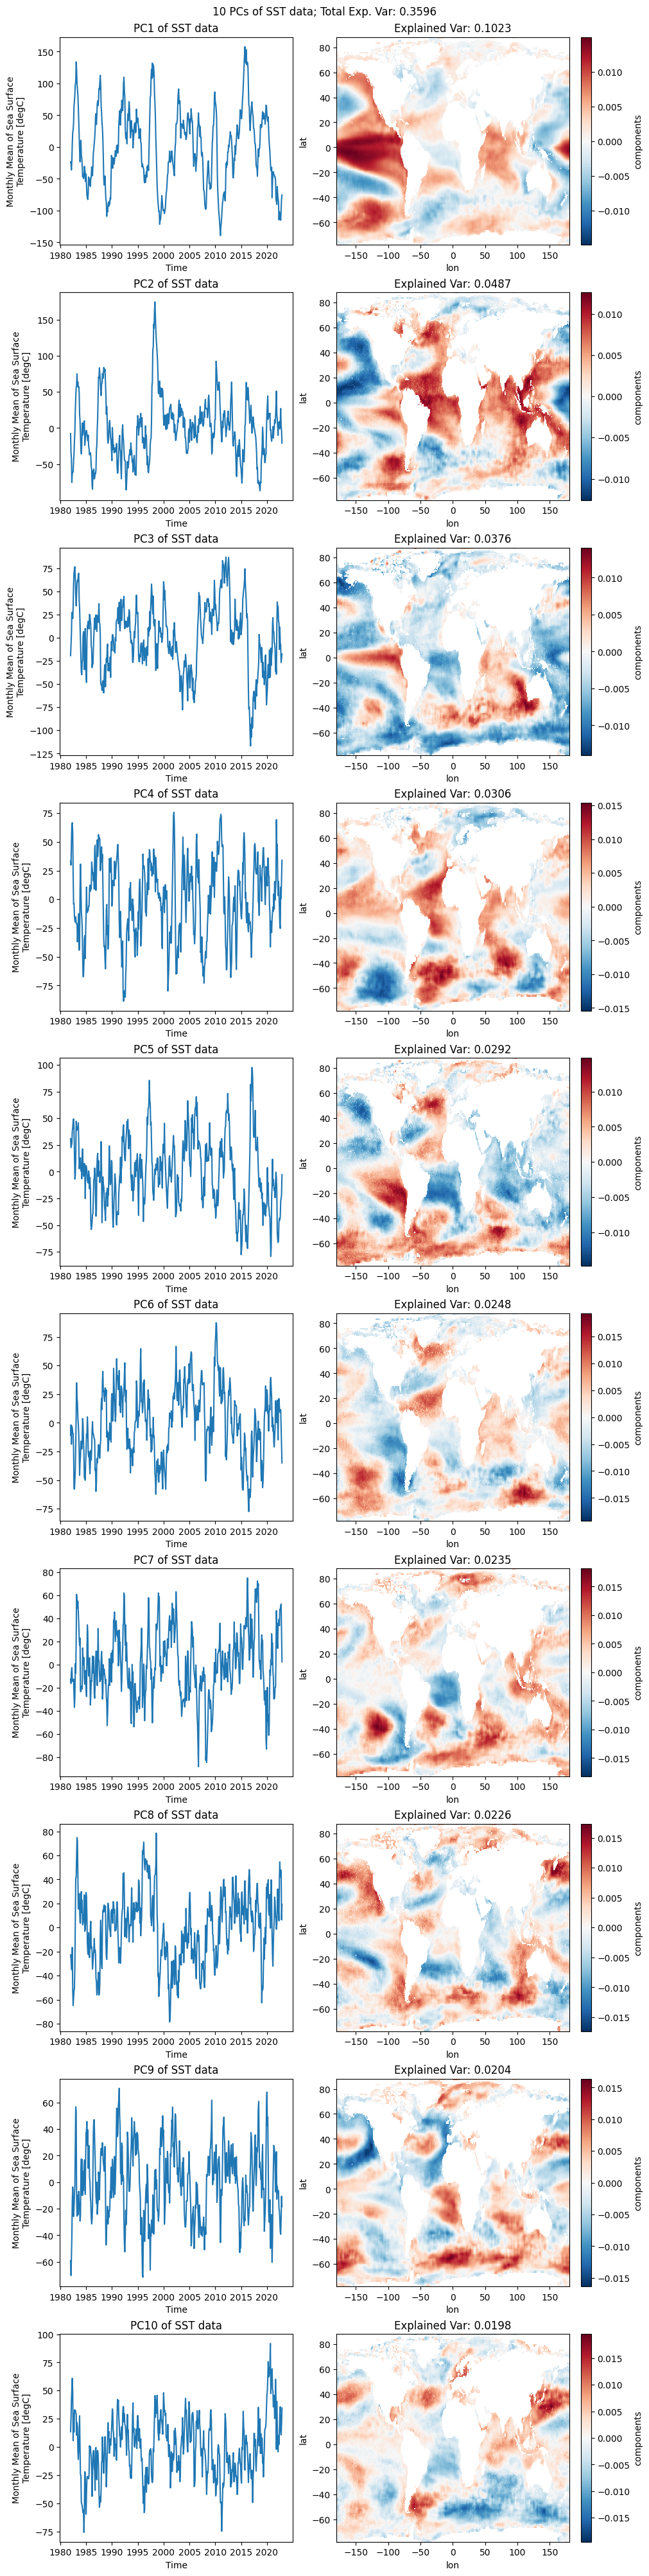

In [36]:
plot_pc_info(sst_pca, sst_pcs)